In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Groceries_dataset.csv")

# Display the first few rows
df.head()


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
df.isnull().sum()


Member_number      0
Date               0
itemDescription    0
dtype: int64

In [4]:
print("Number of unique transactions:", df['Member_number'].nunique())


Number of unique transactions: 3898


In [5]:
print(df['itemDescription'].value_counts().head(10))


itemDescription
whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: count, dtype: int64


In [6]:
# Group items by transaction ID
transactions = df.groupby('Member_number')['itemDescription'].apply(list).tolist()


In [7]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)


In [8]:
from mlxtend.frequent_patterns import apriori, association_rules

# Find frequent itemsets (min_support = 0.01 means 1% of transactions)
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Generate strong association rules (min_confidence = 0.2)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display top rules
rules.sort_values(by="lift", ascending=False).head(10)




,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
15193,"(yogurt, rolls/buns)","(sausage, other vegetables, whole milk)",0.111339,0.050282,0.013597,0.122120,2.428689,1.0,0.007998,1.081831,0.661957,0.091854,0.075641,0.196264
15176,"(sausage, other vegetables, whole milk)","(yogurt, rolls/buns)",0.050282,0.111339,0.013597,0.270408,2.428689,1.0,0.007998,1.218025,0.619400,0.091854,0.178999,0.196264
15182,"(other vegetables, rolls/buns, yogurt)","(sausage, whole milk)",0.052335,0.106978,0.013597,0.259804,2.428575,1.0,0.007998,1.206467,0.620721,0.093310,0.171133,0.193451
15187,"(sausage, whole milk)","(other vegetables, rolls/buns, yogurt)",0.106978,0.052335,0.013597,0.127098,2.428575,1.0,0.007998,1.085650,0.658702,0.093310,0.078893,0.193451
12801,"(sausage, whole milk)","(curd, yogurt)",0.106978,0.040277,0.010005,0.093525,2.322046,1.0,0.005696,1.058742,0.637549,0.072897,0.055483,0.170966
12796,"(curd, yogurt)","(sausage, whole milk)",0.040277,0.106978,0.010005,0.248408,2.322046,1.0,0.005696,1.188173,0.593239,0.072897,0.158372,0.170966
15178,"(sausage, rolls/buns, whole milk)","(other vegetables, yogurt)",0.048743,0.120318,0.013597,0.278947,2.318415,1.0,0.007732,1.219997,0.597810,0.087459,0.180326,0.195977
15191,"(other vegetables, yogurt)","(sausage, rolls/buns, whole milk)",0.120318,0.048743,0.013597,0.113006,2.318415,1.0,0.007732,1.072451,0.646451,0.087459,0.067556,0.195977
15192,"(sausage, rolls/buns)","(other vegetables, yogurt, whole milk)",0.082350,0.071832,0.013597,0.165109,2.298554,1.0,0.007681,1.111724,0.615642,0.096715,0.100496,0.177197
15177,"(other vegetables, yogurt, whole milk)","(sausage, rolls/buns)",0.071832,0.082350,0.013597,0.189286,2.298554,1.0,0.007681,1.131903,0.608665,0.096715,0.116532,0.177197


In [10]:
# Select only strong rules (adjust confidence threshold as needed)
filtered_rules = rules[(rules['confidence'] > 0.5) & (rules['lift'] > 1.2)]

# Limit to top 30 rules for better visualization
filtered_rules = filtered_rules.nlargest(30, 'lift')


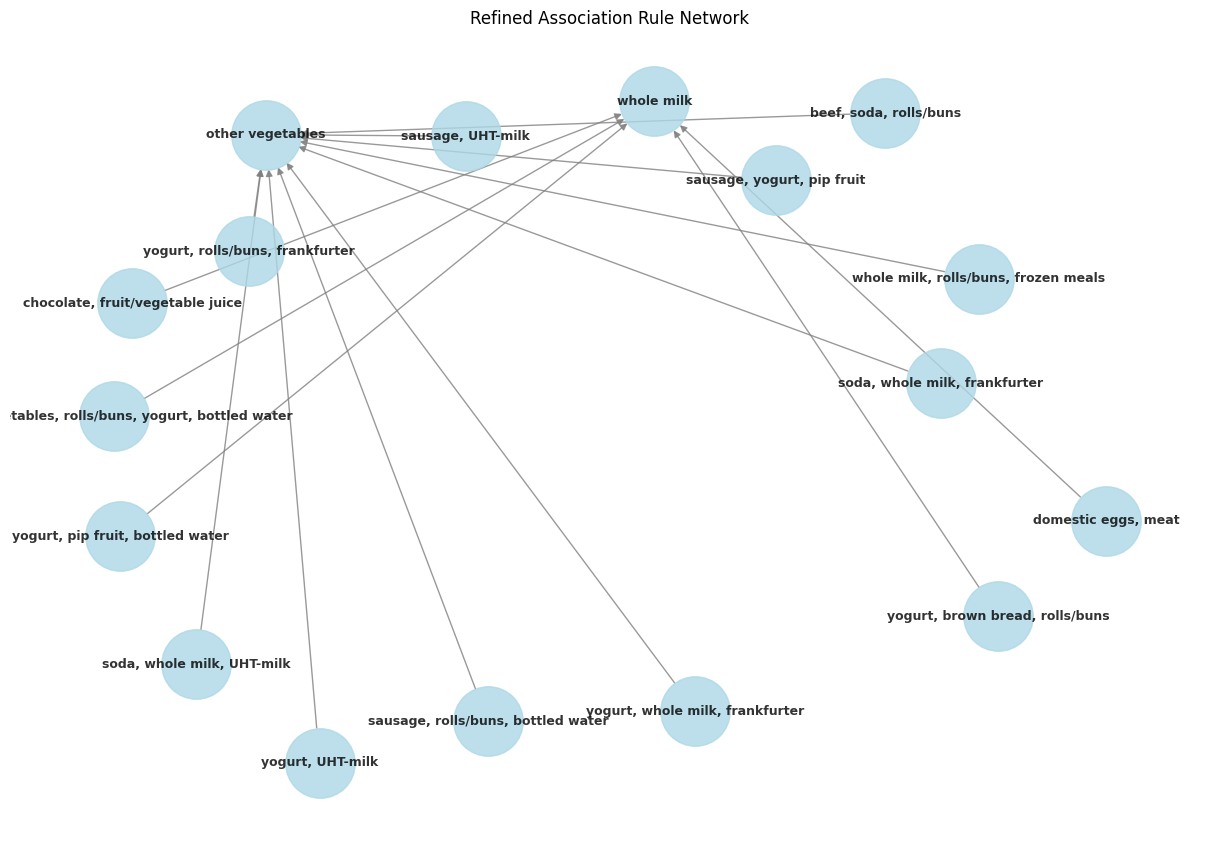

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

# Select only the top 15 strongest rules
filtered_rules = rules[(rules['confidence'] > 0.6) & (rules['lift'] > 1.3)]
filtered_rules = filtered_rules.nlargest(15, 'lift')

# Create directed graph
G = nx.DiGraph()

for _, rule in filtered_rules.iterrows():
    antecedent = ', '.join(rule['antecedents'])
    consequent = ', '.join(rule['consequents'])
    G.add_edge(antecedent, consequent, weight=rule['confidence'])

# Increase spacing between nodes
pos = nx.spring_layout(G, k=1.5)

# Adjust figure size
plt.figure(figsize=(12, 8))

# Draw the network with better visibility
nx.draw(
    G, pos, with_labels=True, node_color="lightblue", edge_color="gray",
    node_size=2500, font_size=9, font_weight="bold", alpha=0.8
)

plt.title("Refined Association Rule Network")
plt.show()
